In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [3]:
import sys
sys.path.append(f'../../../python')

from balance_split_data import create_label, retain_section, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, \
get_feature_importance, get_feature_importance10

### Load data

In [24]:
df = pd.read_json(r"../../../../data/processed/pre-processed_merged_2023_04_03.json")

#### Loop creation of train and test sets by section

In [25]:
label_name = "wc"
section_dict={0:'Parties & Operation', 1:'Concentration & Dimension', 
              2:'Market Definition', 3:'Competitive Assessment'}
random_seed=42
random_state=42

In [26]:
# Loop by section and WC
for section_key in section_dict.keys():
    df1 = create_label(df, label_name)
    df1 = retain_section(df1, section=section_dict[section_key])
    print(df1['section_fin'].value_counts())
    df_unique = balance_unique_id(df1)
    df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=random_seed)
    df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=random_state)
    globals()[f"df_train_grouped_{section_key}"], globals()[f"df_test_grouped_{section_key}"], \
    globals()[f"df_test1_grouped_{section_key}"], globals()[f"df_excluded_grouped_{section_key}"] = group_by_case(df_train, df_test, df_test1, df_excluded)

    globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], globals()[f"X_test_{section_key}"], globals()[f"y_test_{section_key}"], \
    globals()[f"X_test1_{section_key}"], globals()[f"y_test1_{section_key}"], globals()[f"X_test2_{section_key}"], globals()[f"y_test2_{section_key}"] = create_feature_label(globals()[f"df_train_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_test_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_test1_grouped_{section_key}"],
                                                                                                                                                            globals()[f"df_excluded_grouped_{section_key}"])

Parties & Operation    1436
Name: section_fin, dtype: int64
Total decisions: 1435
0    1219
1     216
Name: label, dtype: int64
Balancing...
Total decisions: 432
Labels distribution: 
 0    216
1    216
Name: 0, dtype: int64
Training set shape: (345,) (345,)
Test set shape: (87,) (87,)
Creating df_train 1: 173 0: 172
Creating df_test1 1: 43 0: 44
Creating df_test concatenated with df_excluded with len: 1003
Creating df_test 1: 43 0: 1047
Grouping df_train by case_num 1: 173 0: 172
Grouping df_test by case_num 1: 43 0: 1047
Grouping df_test1 by case_num 1: 43 0: 44
Grouping df_excluded by case_num with len: 1003
Concentration & Dimension    1532
Name: section_fin, dtype: int64
Total decisions: 1532
0    1294
1     238
Name: label, dtype: int64
Balancing...
Total decisions: 476
Labels distribution: 
 1    238
0    238
Name: 0, dtype: int64
Training set shape: (380,) (380,)
Test set shape: (96,) (96,)
Creating df_train 1: 189 0: 190
Creating df_test1 1: 48 0: 48
Creating df_test concatena

### Model training (with 10-fold CV) using best parameters from GridSearch

In [27]:
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

# clf__C: 1
# tfidf__binary: True
# tfidf__max_df: 0.025
# tfidf__ngram_range: (2, 2)
# tfidf__norm: 'l1'
# tfidf__use_idf: False

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


In [27]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (2,2), binary = True, max_df = 0.05, norm = 'l1', use_idf = False))
c = 1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [28]:
df_metrics = pd.DataFrame(columns = ['set', 'section', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [29]:
for section_key in section_dict.keys():
    # balanced train
    globals()[f"pipeline_train_{section_key}"], globals()[f"trained_model_{section_key}"], globals()[f"y_predict_train_{section_key}"] = train_model_cross_val(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], vec=vec, model=model, cv=10)
    globals()[f"df_features_train_{section_key}"], _, _ = get_feature_importance(globals()[f"trained_model_{section_key}"], globals()[f"pipeline_train_{section_key}"])
    metrics_train=evaluate(globals()[f"y_train_{section_key}"],globals()[f"y_predict_train_{section_key}"])
    set = "balanced train"
    section = section_dict[section_key]
    row_train = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                        'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                        'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])
    
    # balanced test
    _, globals()[f"y_predict_test1_{section_key}"] = train_model_test(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], \
                                                     globals()[f"X_test1_{section_key}"], globals()[f"y_test1_{section_key}"], model=model, vec=vec)
    metrics_test1=evaluate(globals()[f"y_test1_{section_key}"],globals()[f"y_predict_test1_{section_key}"])
    set = "balanced test"
    row_test1 = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                        'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                        'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])
    
    # imbalanced test
    _, globals()[f"y_predict_test_{section_key}"] = train_model_test(globals()[f"X_train_{section_key}"], globals()[f"y_train_{section_key}"], \
                                                     globals()[f"X_test_{section_key}"], globals()[f"y_test_{section_key}"], model=model, vec=vec)
    metrics_test=evaluate(globals()[f"y_test_{section_key}"],globals()[f"y_predict_test_{section_key}"])
    set = "imbalanced test"
    row_test = pd.DataFrame({'set':set, 'section':section, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                        'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                        'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

    df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)

df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.6434782608695652

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65       172
           1       0.65      0.64      0.64       173

    accuracy                           0.64       345
   macro avg       0.64      0.64      0.64       345
weighted avg       0.64      0.64      0.64       345


CR: (0.6435294117647059, 0.6435004704933459, 0.6434662790599979, None)

Confusion matrix:
 [[112  60]
 [ 63 110]] 

_______________________


 Accuracy: 64.348 
 Precision: 0.647 
 Recall: 0.636 
 F1: 0.641 
 FPR: 0.349 
 ROC_AUC: 0.644
Accuracy: 0.6434782608695652

Classification report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65       172
           1       0.65      0.64      0.64       173

    accuracy                           0.64       345
   macro avg       0.64      0.64      0.64       345
weighted avg       0.64 

In [30]:
df_metrics

,set,section,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,Parties & Operation,112,60,63,110,0.635838,0.647059,0.641399,0.348837,64.347826,0.643500,345
1,balanced test,Parties & Operation,30,14,13,30,0.697674,0.681818,0.689655,0.318182,68.965517,0.689746,87
2,imbalanced test,Parties & Operation,653,394,13,30,0.697674,0.070755,0.128480,0.376313,62.660550,0.660681,1090
3,balanced train,Concentration & Dimension,100,90,76,114,0.600000,0.558824,0.578680,0.473684,56.315789,0.563158,380
4,balanced test,Concentration & Dimension,29,19,23,25,0.520833,0.568182,0.543478,0.395833,56.250000,0.562500,96
5,imbalanced test,Concentration & Dimension,664,440,23,25,0.520833,0.053763,0.097466,0.398551,59.809028,0.561141,1152
6,balanced train,Market Definition,66,77,13,130,0.909091,0.628019,0.742857,0.538462,68.531469,0.685315,286
7,balanced test,Market Definition,17,19,3,33,0.916667,0.634615,0.750000,0.527778,69.444444,0.694444,72
8,imbalanced test,Market Definition,333,389,3,33,0.916667,0.078199,0.144105,0.538781,48.284960,0.688943,758
9,balanced train,Competitive Assessment,77,89,9,157,0.945783,0.638211,0.762136,0.536145,70.481928,0.704819,332


In [31]:
df_metrics.to_excel('../../../../output/tables/svm_metrics_section_wc.xlsx', index=True)

### Confusion matrix and model performance

### Feature importance

Get features for label = 1 and label = 0

In [33]:
for section_key in section_dict.keys():
    globals()[f"df_features_train1_{section_key}"], globals()[f"df_features_train0_{section_key}"] = get_feature_importance10(globals()[f"df_features_train_{section_key}"])

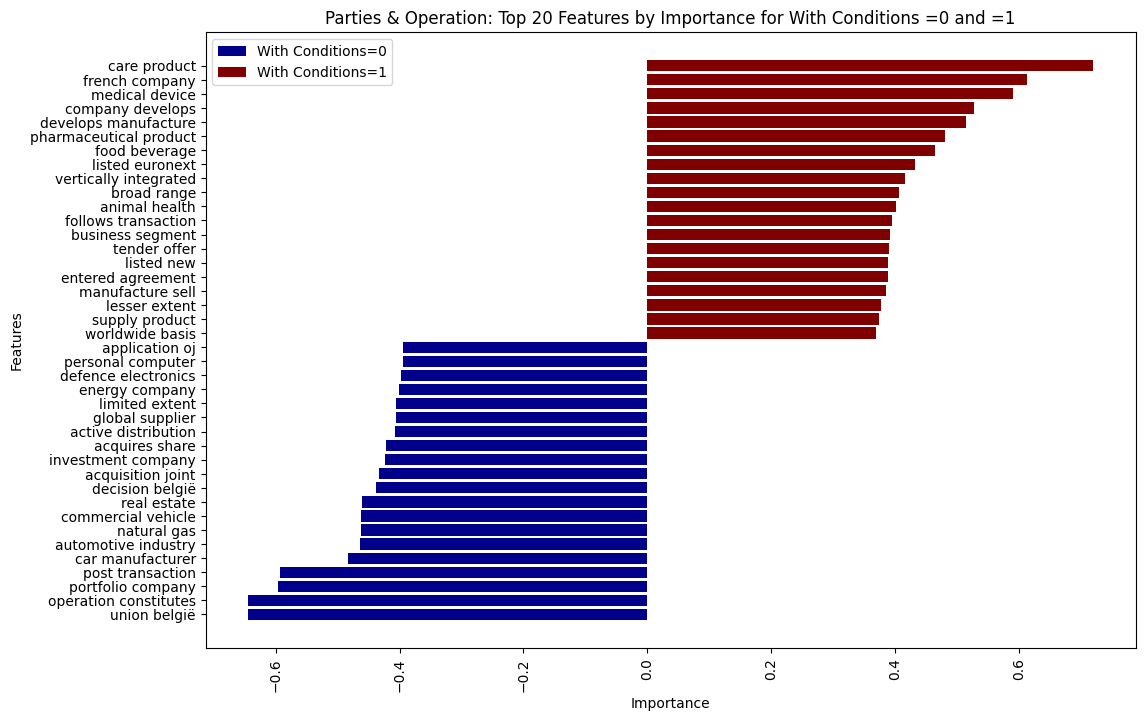

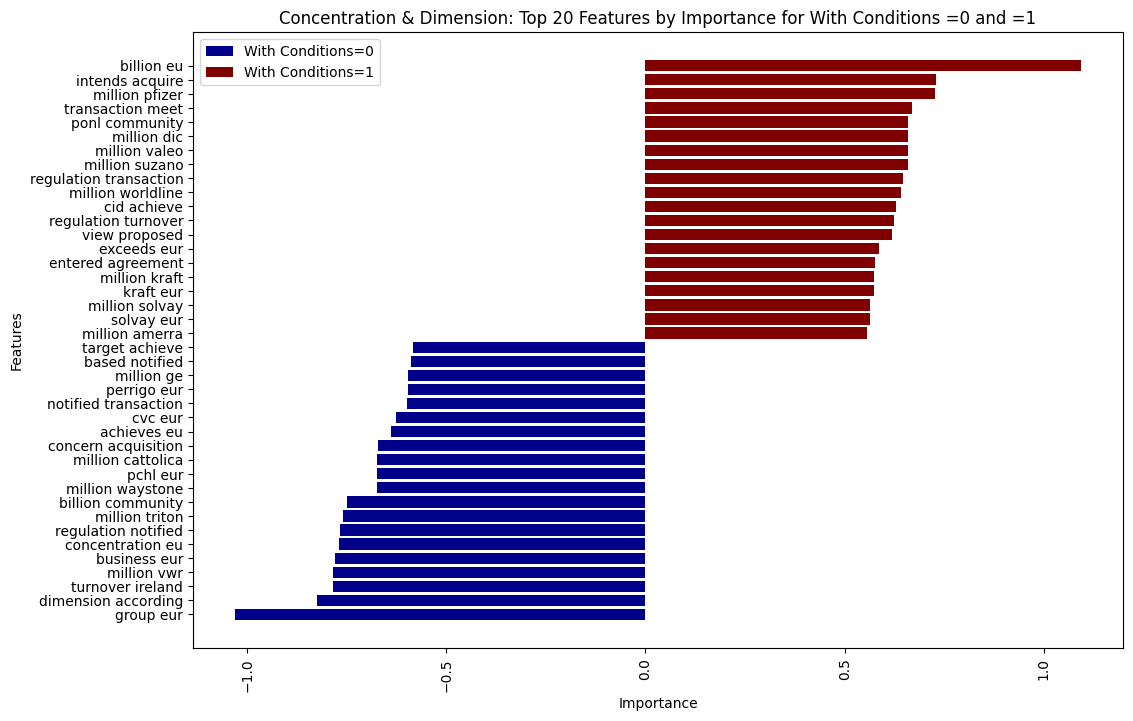

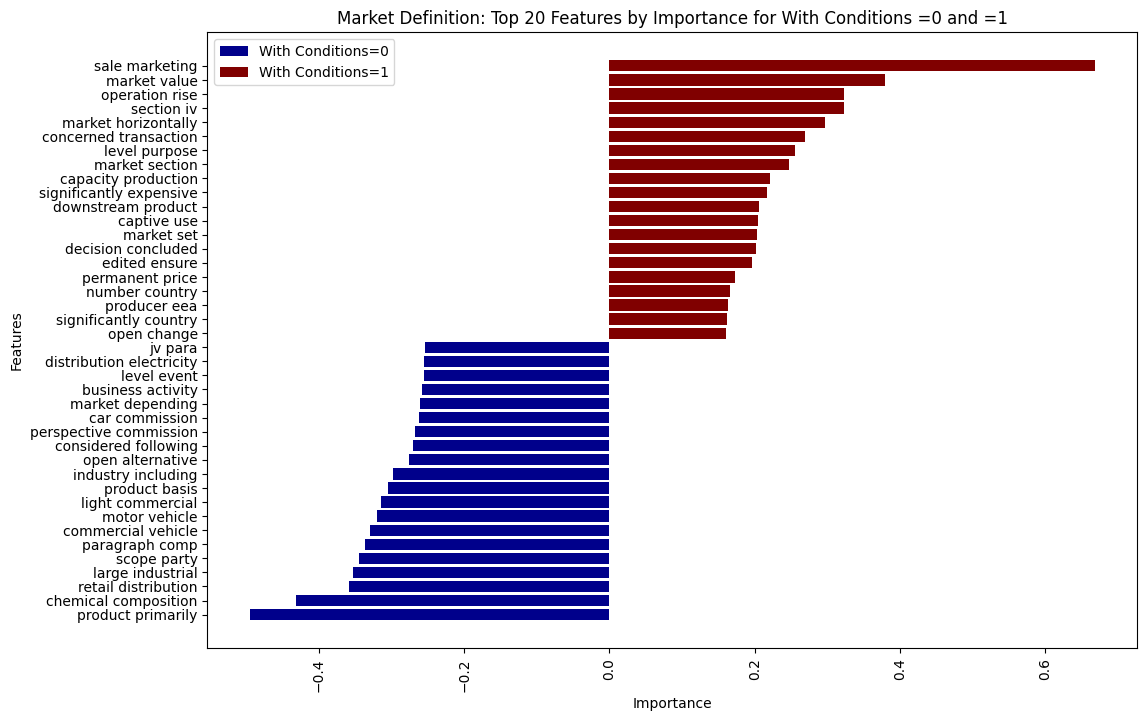

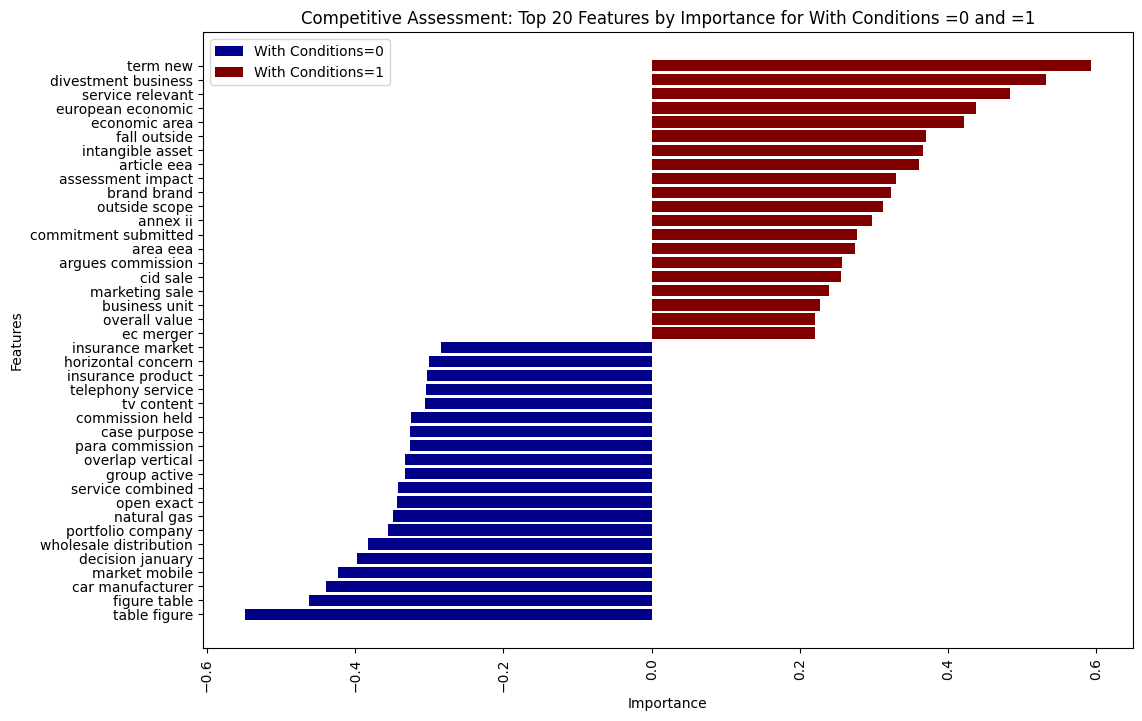

In [38]:
for section_key in section_dict.keys():
    # Sort the features by absolute importance for label=1
    globals()[f"df_features_train1_{section_key}"] = globals()[f"df_features_train1_{section_key}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train1_top10_{section_key}"] = globals()[f"df_features_train1_{section_key}"].nlargest(20, 'abs_importance')
    globals()[f"df_features_train1_top10_{section_key}"] = globals()[f"df_features_train1_top10_{section_key}"].sort_values('importance', ascending=True)

    # Sort the features by absolute importance for label=0
    globals()[f"df_features_train0_{section_key}"] = globals()[f"df_features_train0_{section_key}"].sort_values(by='abs_importance', ascending=False)
    globals()[f"df_features_train0_top10_{section_key}"] = globals()[f"df_features_train0_{section_key}"].nlargest(20, 'abs_importance')

    # Create a combined bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(globals()[f"df_features_train0_top10_{section_key}"]['feature'], globals()[f"df_features_train0_top10_{section_key}"]['importance'], color='darkblue', label='With Conditions=0')
    ax.barh(globals()[f"df_features_train1_top10_{section_key}"]['feature'], globals()[f"df_features_train1_top10_{section_key}"]['importance'], color='maroon', label='With Conditions=1')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title(str(section_dict[section_key])+ ': Top 20 Features by Importance for With Conditions =0 and =1')
    ax.legend()
    plt.xticks(rotation=90)
    #plt.show()

    plt.savefig('../../../../output/figures/svm_section_' + str(section_key) + '.png', bbox_inches='tight')

In [20]:
for section_key in section_dict.keys():
    globals()[f"df_features_train_{section_key}"].to_excel('../../../../output/tables/features_svm_train_wc_' + str(section_key) + '.xlsx', index=True)